In [1]:
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from localGD import localGD
import time
import imageio
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *
import numdifftools as nd

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.Hartmann_6(Noise, Noise_level)

# objective = f_class.Alpine(Noise, Noise_level) 
# objective = f_class.Ackley(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# # objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
objective = f_class.Levy(Noise, Noise_level, dim=10)  
# objective = f_class.Rastrigin(Noise, Noise_level, dim=6)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
# clean_f = lambda x: f_class.Ackley().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
clean_f = lambda x: f_class.Levy(dim=10).func(x)
# clean_f = lambda x: f_class.Rastrigin(dim=6).func(x)
B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]


dim = objective.input_dim
print('dim: ', dim)
# print(f( np.array([dim*[1], dim*[1]])))

[[-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]
 [-2.  2.]]
dim:  10


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

### Grid

In [6]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [7]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [8]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

# BO

In [9]:
MAX = 200 # function observations

## Gradient-based Method

##### 1. Setup

In [10]:
# initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))

# sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)

# X = np.vstack([X, np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))])

In [11]:
gp = GP_grad(B, Noise, Noise_level)
# gp.set_hyper(ls, var)  # if online, skip

gp.set_data(X, f(X))
ls, var = gp.optimize()
gp.set_hyper(ls, var)
gp.fit()

# w: starting point of GD
w = X[0].reshape(1, dim)
history_w = []
history_f = []

##### 2. Warm up

In [12]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
# warmup = 30
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history_warmup.append( (w, f(w)) )
    
# X_fix = X

In [13]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
warmup = 10
history_warmup = []
for i in range(1, warmup+1):
    w = gp.thompson_sample(n_mesh=gp.dim*100)
    gp.add_data(w.reshape(1, dim), f(w))
    if i % 5 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()    
                
    X = np.vstack([X, w])
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    history_warmup.append( (w, f(w)) )
    
X_fix = X

1, w:  [-0.11614335 -0.27362955  0.11234045 -1.55369729  0.06004262 -0.89897799
  1.56570721 -1.06764525  0.75764656  1.80702615], f(w):  6.415917083698332, 
2, w:  [ 1.51820803 -0.98448944  0.94887567 -1.37561178  0.14646459  1.78598595
 -0.44013989  0.29636049  1.06547475  1.25811219], f(w):  4.259078625471363, 
3, w:  [ 1.12912321 -0.40152538  1.64668369  1.30034995  0.97188258  1.67793107
  1.60162807 -0.92130065 -0.94528675 -0.16141784], f(w):  2.828758829545506, 
4, w:  [ 0.32611036 -0.99642956  1.60769439  1.60236502  0.3270607   0.13635755
 -0.25748193 -1.94690645 -0.91725838 -1.05660534], f(w):  8.660106907894695, 
  # Optimal (ls, var) =  (1.0, 67.96003080309646)
5, w:  [ 1.59674859 -1.72709495 -1.79896963 -1.03900623  0.62778783  1.37315702
 -1.0056259  -0.63602114  1.3119328   1.2550478 ], f(w):  11.836954808287972, 
6, w:  [-0.25693262  1.83617449  0.92226648  0.53362226  0.44883728 -0.72622609
  1.65631247 -1.01951653 -1.39608997  1.34310079], f(w):  5.5603621613941066, 


##### 3. Optimize via GD

In [14]:
w = gp.X[np.argmin(gp.y)]
optimizer = localGD(gp, B, w, f)

from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

(array([[-0.07206588, -0.04886914, -0.00464839,  0.02476096, -0.05721811,
         -0.13773689, -0.16201809, -0.08914273,  0.00223647, -0.07544962]]),
 array([[ 5.76748939, 15.84555777, 15.64545622, -8.71643296,  4.01725939,
         12.89959155,  2.2352199 ,  8.24828803, -4.76844673, -3.08611023]]),
 array([ 0.15820941, -0.38590193,  0.91175032,  0.39991489, -0.02732882,
         0.94819638,  0.85469717, -2.35253876, -2.47644874, -0.21690583]))

In [15]:
gp.optimize()
gp.fit()
np.set_printoptions(precision=4)
stall = False
cost = setup + warmup

desc = - optimizer._grad()

lr = 0.01
while cost <= MAX:
    # update w 
    if optimizer.FAIL >= optimizer.STOP or stall:
        print()
        print('New Local Search: ',)
        print('Fail = ', optimizer.FAIL, end = ', ')
        print('Norm = ', LA.norm(desc))
        
        # 1. random draw
#         w = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
        
#         2. UCB draw
#         w, _ = gp.ucb_minimize(cost**2)
#         gp.add_data(w.reshape(1, -1), f(w))
        
#         many UCB draws, pick the best
#         history_warmup = []
#         ucb_alternate = 20
#         for i in range(1, ucb_alternate+1):
#             b = np.log(i)
#             w, fw = gp.ucb_minimize(b)
#             if i == 1:
#                 X = w
#             else:
#                 X = np.vstack([X, w])

# #             print(i, end = ', ')
# #             print('w: ', w, end = ', ')
# #             print('f(w): ', f(w).item(), end = ', ')
# #             print()

#             gp.add_data(w.reshape(1, dim), f(w))
#             if i % 5 == 0:
#                 ls, var = gp.optimize()
#                 print('  # Optimal (ls, var) = ', (ls, var))
#             gp.fit()
#             history_warmup.append( (w, f(w)) )
            
#         w = X[np.argmin(f(X))]
            
        
        # thompson sampling
        w = gp.thompson_sample(n_mesh=gp.dim*100)
        gp.add_data(w.reshape(1, -1), f(w)) 
        
        # tune back setting
        cost += 1
        stall = False
        
        history_w.append(optimizer.history_w)
        history_f.append([f(w).item() for w in optimizer.history_w])
        optimizer = localGD(gp, B, w, f)
    else:
        w, desc = optimizer.update(y_best=np.min(f(gp.X)), commit= True)
        if is_new(w, gp.X) == False:
            print('  ** hit past points')
            stall = True
            continue
            
        gp.add_data(w.reshape(1, -1), f(w))
        cost += 1
    
    
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()

    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print(cost, end = '. ')
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.6f ' % f(w).item())
    print('       d(w): ', np.squeeze(m))
    print('       s.d: ', np.squeeze(v))
    print('       g(w):', optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))
    print('       lr: %.4f' % lr)
    print()
        
print('Max Cost reached = ', cost)
history_w.append(optimizer.history_w)
history_f.append([f(w).item() for w in optimizer.history_w])

0.05
GD update:  0
  # Optimal (ls, var) =  (1.0, 56.19773662247998)
12.     w:  [ 1.122  -0.3762  1.6122  1.2907  0.9868  1.6729  1.5999 -0.9239 -0.9344
 -0.1492],     f(w): 2.754294 
       d(w):  [ 0.1466 -0.8236  1.0512  0.3202 -0.5143  0.0182 -0.1051 -0.0091 -0.3306
 -0.4479]
       s.d:  [7.4203 6.464  5.433  7.3553 7.1537 7.4578 7.4906 7.4863 7.3177 7.2693]
       g(w): [ 0.1496 -0.3329  0.8685  0.385  -0.0131  0.9425  0.8524 -2.3657 -2.4201
 -0.221 ]
       lr: 0.0100

0.05
GD update:  0
13.     w:  [ 1.1447 -0.3599  1.617   1.2716  0.9635  1.6738  1.62   -0.9162 -0.9248
 -0.1341],     f(w): 2.724409 
       d(w):  [-0.0543 -0.9546  0.9937  0.4849 -0.2945  0.0179 -0.2739 -0.0719 -0.4127
 -0.5721]
       s.d:  [6.5598 6.076  5.3406 6.8108 6.1578 7.4558 6.8474 7.3944 7.1923 6.942 ]
       g(w): [ 0.177  -0.3011  0.8748  0.3556 -0.0351  0.9436  0.8786 -2.3265 -2.3704
 -0.2257]
       lr: 0.0100

0.05
GD update:  0
14.     w:  [ 1.1567 -0.354   1.6215  1.2772  0.9948  1.691   1.641

0.05
0.05
GD update:  1
  # Optimal (ls, var) =  (1.0, 26.591438273872292)
30.     w:  [-1.8927 -0.5104 -0.5573 -1.5268 -0.2691 -0.5437  0.6719 -1.646   1.3944
 -0.6621],     f(w): 8.674619 
       d(w):  [ 0.1603 -0.7008 -0.6287 -0.6737  0.6836  0.2659 -0.7349 -2.5954  2.2532
  3.1902]
       s.d:  [4.0692 2.8319 4.2648 4.1415 4.7043 4.0857 3.9732 2.9617 2.4157 2.4698]
       g(w): [ 0.7743 -0.661  -0.8037 -5.3963 -0.1535 -0.761  -0.1758 -5.7628  0.5475
 -0.0242]
       lr: 0.0100

0.05
GD update:  0
31.     w:  [-1.9094 -0.4589 -0.6055 -1.5364 -0.2466 -0.5493  0.6579 -1.5998  1.4028
 -0.6925],     f(w): 8.471165 
       d(w):  [ 0.4962 -1.0443 -0.3631 -0.5875  0.608   0.3639 -0.6709 -2.9502  2.1468
  3.4615]
       s.d:  [2.1441 2.3402 3.5523 4.134  4.2808 3.9858 3.8746 2.8629 2.2817 2.4453]
       g(w): [ 0.7775 -0.5212 -0.965  -5.4311 -0.1246 -0.7782 -0.1764 -5.638   0.5607
 -0.0259]
       lr: 0.0100

0.05
GD update:  0
32.     w:  [-1.9193 -0.465  -0.6031 -1.5398 -0.209  -0.5696 

0.05
0.05
0.05
0.05
0.005
0.005
0.05
0.005
0.05
0.005
0.05
0.005
0.005
0.05
0.005
0.05
0.05
0.005
0.05
0.005
0.005
0.05
0.05
0.05
0.005
0.05
0.005
0.05
0.005
0.05
0.05
0.05
0.005
0.05
0.05
0.05
0.05
0.05
0.05
GD update:  40
  # Optimal (ls, var) =  (1.0, 18.597985126138404)
48.     w:  [-1.9616 -0.6704  0.0285 -0.6423 -0.3102 -0.4726  0.9758 -0.6262  1.1051
 -0.9796],     f(w): 2.083811 
       d(w):  [ 0.5191 -0.4331  0.2251 -0.7518 -0.1347  0.5936 -0.4373  0.2631 -0.2077
  0.0952]
       s.d:  [2.9264 2.3837 2.1147 3.0672 3.1845 2.8018 2.2978 2.8211 2.7546 2.4475]
       g(w): [ 0.784  -1.2055  0.0231 -1.0982 -0.2141 -0.5566 -0.0236 -1.0389  0.12
 -0.2231]
       lr: 0.0100

0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.005
0.05
0.05
0.005
0.05
0.005
0.05
0.005
GD update:  15
49.     w:  [-1.9682 -0.5736 -0.0083 -0.4226 -0.2997 -0.4825  0.9892 -0.6544  1.0976
 -0.8953],     f(w): 1.834568 
       d(w):  [ 0.4968 -0.6143  0.3568 -0.8177 -0.2288  0.6214 -0.4342  0.4353 -0.2261
 -0.1364]
  

0.05
0.05
0.05
0.05
GD update:  4
  # Optimal (ls, var) =  (1.0, 17.3252248635342)
66.     w:  [ 0.7746  0.0021  0.893   1.1599 -1.4783  0.5859 -0.6728  1.2786  0.9439
 -1.8588],     f(w): 4.492728 
       d(w):  [-0.1081 -0.1468 -2.1013 -0.1674 -5.7322  1.9299 -1.7435 -0.5945 -0.1518
  0.0965]
       s.d:  [1.6571 1.9325 2.7713 2.8295 0.8969 3.075  1.5337 1.5629 1.7381 2.1217]
       g(w): [-0.2724  0.0227 -0.0921  0.1925 -5.209  -0.1717 -1.2148  0.3663 -0.0523
 -1.0417]
       lr: 0.0100

0.05
0.05
0.05
GD update:  2
67.     w:  [ 0.7876  0.0169  0.9306  1.1189 -1.3872  0.6044 -0.6522  1.2681  0.9465
 -1.8188],     f(w): 3.949003 
       d(w):  [-0.2971 -0.0841 -1.8545 -0.556  -5.5051  1.8596 -1.5333 -0.6001 -0.3388
  0.1658]
       s.d:  [1.8569 1.6123 2.0313 1.5044 1.3282 3.0859 1.8201 1.85   1.9345 2.1241]
       g(w): [-0.2572  0.0232 -0.0635  0.1378 -4.8087 -0.1741 -1.1353  0.3503 -0.0501
 -1.0973]
       lr: 0.0100

0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
GD

0.005
GD update:  0
  # Optimal (ls, var) =  (1.0, 17.614389477435747)
84.     w:  [ 1.1214 -0.3595 -0.0421  1.3906  0.8345 -1.9267 -1.9458 -1.3262  1.4972
 -1.0627],     f(w): 14.050414 
       d(w):  [-0.1008  0.0059 -0.03   -1.0624 -0.3686  0.228  -0.7667 -0.2193 -0.4222
  0.9231]
       s.d:  [4.1853 4.0922 4.196  3.2176 1.6301 4.126  3.7584 4.0529 4.0239 3.503 ]
       g(w): [ 0.1489 -0.3004  0.0166  0.5416 -0.1283 -5.9372 -5.9079 -4.5126  0.7065
 -0.342 ]
       lr: 0.0100

0.005
0.005
GD update:  1
85.     w:  [ 1.1172 -0.362  -0.0417  1.4004  0.8343 -1.9245 -1.9439 -1.326   1.4972
 -1.0647],     f(w): 14.031349 
       d(w):  [ 0.2911  0.2332 -0.0516 -1.5498 -0.3207 -0.0377 -0.6957 -0.1525 -0.3081
  0.8069]
       s.d:  [3.513  3.8743 4.1945 2.1462 1.6016 3.8003 3.6989 4.0244 3.9479 3.3594]
       g(w): [ 0.1438 -0.3051  0.0167  0.557  -0.1284 -5.9402 -5.911  -4.5114  0.7065
 -0.3453]
       lr: 0.0100

0.005
GD update:  0
86.     w:  [ 1.1175 -0.3651 -0.0419  1.4003  0.8343 -1

0.05
GD update:  0
  # Optimal (ls, var) =  (1.0, 18.854370903627565)
102.     w:  [ 1.0841  1.109  -1.5001 -0.3969 -0.6886  0.4919 -0.817   0.4476 -0.7469
 -1.4645],     f(w): 5.224038 
       d(w):  [-0.0794  0.1063 -0.1928  0.0875  0.0448  0.1635  0.1698  0.0919  0.2968
  0.0914]
       s.d:  [4.2864 4.2111 3.9062 4.2814 4.3144 4.0763 4.058  4.2679 3.4645 4.2545]
       g(w): [ 0.1034  0.1251 -5.2957 -0.376  -1.2775 -0.1484 -1.8389 -0.1321 -1.5214
 -1.0375]
       lr: 0.0100

0.05
GD update:  0
103.     w:  [ 1.0913  1.1041 -1.4844 -0.4072 -0.6781  0.5252 -0.8189  0.4376 -0.7568
 -1.439 ],     f(w): 5.121279 
       d(w):  [-0.3829  0.3056 -0.8454  0.5226 -0.4173 -1.3013  0.2285  0.5131  0.687
 -1.0247]
       s.d:  [4.2435 4.1929 3.6846 4.1922 4.2133 2.8224 4.0573 4.1843 3.3799 3.6168]
       g(w): [ 0.1123  0.1188 -5.2336 -0.3984 -1.2356 -0.1585 -1.8478 -0.1281 -1.5648
 -1.0016]
       lr: 0.0100

0.05
GD update:  0
104.     w:  [ 1.0858  1.0979 -1.4822 -0.4154 -0.6768  0.5299 -0.

0.005
0.05
0.05
GD update:  5
119.     w:  [ 1.1293  1.3667 -0.5571 -0.5442 -0.5422  0.5904 -0.2052  0.4159 -0.6427
 -1.1883],     f(w): 1.605825 
       d(w):  [ 0.5052 -0.0683 -0.0709 -0.9799 -0.095  -0.2927 -0.1054 -0.0156 -0.1035
 -0.1454]
       s.d:  [2.0902 2.5167 2.0352 2.3228 2.9838 1.4908 2.1247 1.7644 2.4302 2.6208]
       g(w): [ 0.1585  0.504  -0.803  -0.7625 -0.7561 -0.1723 -0.0789 -0.1189 -1.0997
 -0.5589]
       lr: 0.0100


New Local Search: 
Fail =  1, Norm =  6.16872525865941
  # Optimal (ls, var) =  (1.0, 16.907417981008788)
120.     w:  [ 1.5215  0.5826 -0.3602  0.3591 -1.1082 -1.5226  1.6778  1.5581 -0.6707
 -0.6331],     f(w): 5.953900 
       d(w):  [-0.0064  0.0053  0.0067 -0.0125  0.0069  0.0193 -0.016  -0.0092  0.0045
 -0.0037]
       s.d:  [4.1118 4.1118 4.1118 4.1118 4.1118 4.1115 4.1115 4.1117 4.1119 4.1118]
       g(w): [ 0.5738 -0.1711 -0.3016 -0.093  -3.352  -5.3808  0.948   0.7953 -1.2069
 -0.0255]
       lr: 0.0100

0.05
GD update:  0
121.     w:  [ 1

0.05
0.005
0.05
0.05
0.05
0.05
0.05
0.05
0.005
0.005
0.005
0.05
0.05
0.05
0.005
0.05
0.05
0.005
0.05
0.05
0.05
0.05
0.05
0.05
GD update:  24
137.     w:  [ 1.1915  0.7665 -0.4056  0.8345 -0.555  -0.6856  1.2193  1.3892 -0.2664
 -0.6793],     f(w): 1.217668 
       d(w):  [-0.5277 -0.5813  0.8379  0.0234 -0.9576 -0.1041  0.7253  0.0094 -0.3821
  0.1204]
       s.d:  [2.3589 2.807  2.9662 2.2285 2.5182 2.7275 2.2214 3.1729 2.3073 2.4162]
       g(w): [ 0.2328 -0.1575 -0.3948 -0.1283 -0.7965 -1.2658  0.2771  0.5394 -0.1499
 -0.0247]
       lr: 0.0100

0.05
0.05
0.05
GD update:  2
  # Optimal (ls, var) =  (1.0, 15.500669596970113)
138.     w:  [ 1.236   0.71   -0.3829  0.8401 -0.5158 -0.6305  1.2249  1.3802 -0.2376
 -0.6946],     f(w): 1.129946 
       d(w):  [-0.681  -0.1412  0.6834 -0.1014 -1.1109 -0.4506  0.6554  0.0546 -0.319
  0.2912]
       s.d:  [2.2602 2.175  2.9243 2.1646 2.3252 1.9373 2.1802 3.1635 2.3098 2.3656]
       g(w): [ 0.2845 -0.1715 -0.3465 -0.1252 -0.6769 -1.0545  0.28

0.05
GD update:  1
155.     w:  [ 1.1176 -0.3315  1.1083  0.4065 -1.1817  0.7975 -0.1488 -1.5281  0.2945
 -0.5574],     f(w): 5.363647 
       d(w):  [-0.9948  1.0962  1.1426  1.6605 -2.1259 -1.2572 -0.9052 -3.6497  1.0273
  0.3736]
       s.d:  [1.5285 2.9631 2.6942 2.9965 2.6686 1.6806 2.3168 2.5148 2.5183 2.7849]
       g(w): [ 0.1442 -0.2494  0.1242 -0.1148 -3.7531 -0.1459 -0.0314 -5.401  -0.0621
 -0.0403]
       lr: 0.0100

0.05
0.05
0.05
0.05
GD update:  3
  # Optimal (ls, var) =  (1.0, 15.226629827457003)
156.     w:  [ 1.1652 -0.3875  1.094   0.3903 -1.141   0.8172 -0.1022 -1.4417  0.2518
 -0.5585],     f(w): 4.787226 
       d(w):  [-1.0144  0.6468  1.256   1.3441 -1.8845 -1.2785 -0.5667 -3.1702  1.0167
  0.4946]
       s.d:  [1.2872 1.8983 2.4711 3.0126 2.7549 1.8578 2.1632 2.3166 2.1293 2.6481]
       g(w): [ 2.0148e-01 -3.5603e-01  1.0620e-01 -1.0755e-01 -3.5313e+00 -1.3702e-01
 -4.1867e-03 -5.0550e+00 -4.1955e-02 -3.9980e-02]
       lr: 0.0100

0.05
0.005
0.05
0.05
0.05
0.

0.05
0.05
0.005
0.005
0.005
GD update:  7
172.     w:  [ 1.0073 -0.0316  0.981   0.4902 -0.3863  1.0007 -0.2126 -0.5518  0.0736
 -0.2448],     f(w): 0.875800 
       d(w):  [ 0.1225 -0.0978  0.0931  0.1005 -0.4999 -0.2485 -0.0192 -0.0421  0.483
  0.1492]
       s.d:  [1.7839 1.2856 1.9546 2.1807 1.3212 2.0741 2.629  1.7287 1.8166 1.9248]
       g(w): [ 8.9568e-03  1.8712e-02 -1.8738e-02 -1.4780e-01 -3.5353e-01  6.7377e-04
 -8.6357e-02 -7.8614e-01  1.8703e-02 -1.8352e-01]
       lr: 0.0100


New Local Search: 
Fail =  1, Norm =  5.4755926101383245
173.     w:  [ 1.5659 -0.7456 -1.7782  0.704  -1.6487  0.3594 -1.7807 -1.1661  1.9312
 -0.9815],     f(w): 16.175478 
       d(w):  [-0.0073  0.0071  0.0241 -0.0046  0.0214 -0.0046  0.0115  0.0063 -0.0189
  0.0054]
       s.d:  [3.7405 3.7405 3.7404 3.7405 3.7405 3.7405 3.7405 3.7405 3.7405 3.7405]
       g(w): [ 0.6098 -1.5159 -5.9791 -0.1724 -5.7694 -0.0932 -5.981  -3.6686  1.1163
 -0.2255]
       lr: 0.0100

0.005
GD update:  0
  # Optimal 

0.005
0.005
GD update:  1
190.     w:  [-0.0893 -1.1044  0.506   1.4703 -1.5808  0.4145 -0.1988 -1.0127 -1.6804
 -1.8632],     f(w): 11.766420 
       d(w):  [-1.9197 -1.8939 -1.8268  3.3961 -2.5257 -2.1432  1.3357 -1.5018 -2.8419
 -2.1436]
       s.d:  [3.2999 3.2201 3.4507 2.5558 3.4489 2.3769 2.2817 2.5221 2.3168 2.8695]
       g(w): [-0.7777 -3.3313 -0.1529  0.6656 -5.5801 -0.1183 -0.0727 -2.833  -5.8399
 -1.0349]
       lr: 0.0100


New Local Search: 
Fail =  5, Norm =  5.231590139813948
191.     w:  [-1.295  -1.337   1.8359  0.2569 -1.197   1.5098  0.0119 -0.4196  0.1895
 -0.1415],     f(w): 6.023488 
       d(w):  [ 0.0469  0.0138 -0.0697  0.0184  0.0136 -0.1111  0.0501 -0.0757  0.0489
 -0.0045]
       s.d:  [4.0467 4.0577 4.0582 4.0598 4.0595 4.059  4.0601 4.0582 4.0599 4.0599]
       g(w): [ 0.3511 -4.5662  1.0832 -0.0443 -3.8361  0.7253  0.0231 -0.4263 -0.0151
 -0.2234]
       lr: 0.0100

0.05
GD update:  0
  # Optimal (ls, var) =  (1.0, 16.433002771471866)
192.     w:  [-1.3

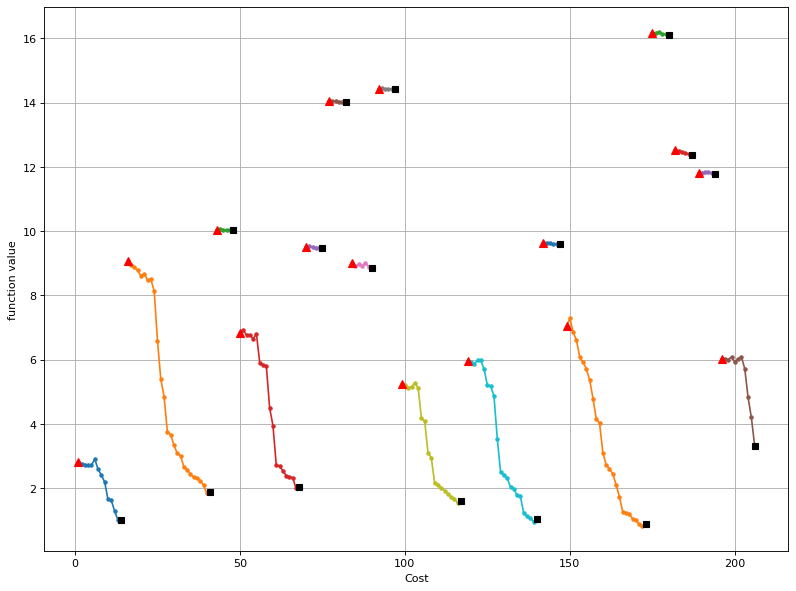

In [16]:
pl.figure(figsize=(12, 9), dpi=80)
axis = 1
for l in history_f:
    pl.plot(np.arange(axis, axis+len(l)), l, "-o", markersize=3)
    pl.plot(axis, l[0], "r^", markersize=8)
    pl.plot(axis+len(l)-1, l[-1], "ks")
    axis += len(l) + 1 # COST includes setup


pl.plot()

pl.xlabel("Cost")
pl.ylabel("function value")
pl.grid(True)

## Minima of GD

In [17]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([ 1.0261, -0.1165,  0.9921,  0.4933, -0.3024,  0.9968, -0.2177,
        -0.5156,  0.0034, -0.218 ]),
 0.8194773124163398,
 170)

In [18]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *Thompson Sampling, UCB*

In [19]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history = [(w, f(w)) for w in X]

In [20]:
cost = setup + warmup
while cost < MAX:

    # 1. Thompson Sampling
    w = gp.thompson_sample(n_mesh=4000)
    # 2. GP_UCB
#     b = np.log(cost)
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    
    
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print()
    
    history.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

11. w:  [0.833  0.0068 0.2991 0.9576 0.1855 0.7287]
  f(w):  -0.00887622323811044

12. w:  [0.065  0.7064 0.5697 0.4672 0.9558 0.8675]
  f(w):  -0.10245723191464683

  # Optimal (ls, var) =  (0.3173961471569036, 0.11907835983548315)
13. w:  [0.4652 0.2452 0.964  0.0294 0.468  0.4823]
  f(w):  -0.3453129482739753

14. w:  [0.3201 0.2895 0.7861 0.3262 0.169  0.9303]
  f(w):  -1.7458784470738113

15. w:  [0.445  0.3112 0.7119 0.5467 0.2059 0.9317]
  f(w):  -1.214407857246848

  # Optimal (ls, var) =  (0.30145264571488617, 0.21600212286995887)
16. w:  [0.5653 0.4208 0.8113 0.1685 0.1679 0.7864]
  f(w):  -1.2660843265258304

17. w:  [0.3955 0.1532 0.898  0.3072 0.2513 0.9593]
  f(w):  -1.2629203734861347

18. w:  [0.2505 0.4389 0.6398 0.3034 0.0909 0.827 ]
  f(w):  -1.2556991484871336

  # Optimal (ls, var) =  (0.3143465899660694, 0.1997564490389683)
19. w:  [0.2768 0.4559 0.8348 0.229  0.1301 0.8639]
  f(w):  -1.5381985544576076

20. w:  [0.0318 0.6149 0.8963 0.0884 0.3931 0.0094]
  f(w): 

91. w:  [0.1502 0.2519 0.4337 0.298  0.4002 0.7083]
  f(w):  -2.7311668506674134

92. w:  [0.0771 0.1564 0.429  0.1879 0.4061 0.6106]
  f(w):  -2.5306201527684813

93. w:  [0.167  0.0998 0.4199 0.2956 0.3151 0.6547]
  f(w):  -3.238557098204487

  # Optimal (ls, var) =  (0.3109086024004871, 0.3972137466219431)
94. w:  [0.2573 0.2919 0.4196 0.298  0.3801 0.6283]
  f(w):  -2.7905506526033563

95. w:  [0.3268 0.1992 0.2582 0.2697 0.3374 0.6767]
  f(w):  -2.862040884393212

96. w:  [0.1591 0.1221 0.4212 0.336  0.2622 0.6553]
  f(w):  -3.0502105072586256

  # Optimal (ls, var) =  (0.31378189426337944, 0.4162949427373685)
97. w:  [0.2776 0.0782 0.5622 0.3617 0.3181 0.5769]
  f(w):  -2.754980305077496

98. w:  [0.2434 0.1256 0.3072 0.3261 0.3543 0.7622]
  f(w):  -2.7332097320775985

99. w:  [0.3547 0.0751 0.3832 0.3254 0.3329 0.5711]
  f(w):  -2.723135931540868

  # Optimal (ls, var) =  (0.31527982105791647, 0.41312590160356316)
100. w:  [0.1304 0.1439 0.5217 0.2791 0.3076 0.6004]
  f(w):  -3.

169. w:  [0.9722 0.8935 0.0455 0.3402 0.0072 0.2011]
  f(w):  -0.007875462927613805

170. w:  [0.3431 0.9428 0.8011 0.9857 0.1151 0.0138]
  f(w):  -0.5320562440418243

171. w:  [7.4933e-01 6.5881e-02 6.5363e-01 9.5604e-01 1.1058e-01 6.4573e-04]
  f(w):  -0.0006889311264353472

  # Optimal (ls, var) =  (0.5837660909403515, 40.08054672092384)
172. w:  [0.8494 0.2149 0.0941 0.0246 0.0961 0.914 ]
  f(w):  -0.12306371955992526

173. w:  [0.9914 0.9596 0.9802 0.0386 0.7448 0.3245]
  f(w):  -0.00036947141047996725

174. w:  [0.8655 0.9993 0.1185 0.394  0.3449 0.9001]
  f(w):  -0.03606270393933246

  # Optimal (ls, var) =  (0.3138096981330823, 0.31023429964043553)
175. w:  [0.1859 0.2816 0.5331 0.1685 0.3302 0.618 ]
  f(w):  -2.7947900238884134

176. w:  [0.1706 0.1828 0.3338 0.2972 0.3401 0.6035]
  f(w):  -3.0089035187817665

177. w:  [0.1968 0.2926 0.6528 0.3155 0.3471 0.7177]
  f(w):  -2.6930026614232774

  # Optimal (ls, var) =  (0.6436652436529054, 99.9302618913718)
178. w:  [0.1657 0.416

<ipython-input-21-fb0ecf9569b4>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
<ipython-input-21-fb0ecf9569b4>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=1)


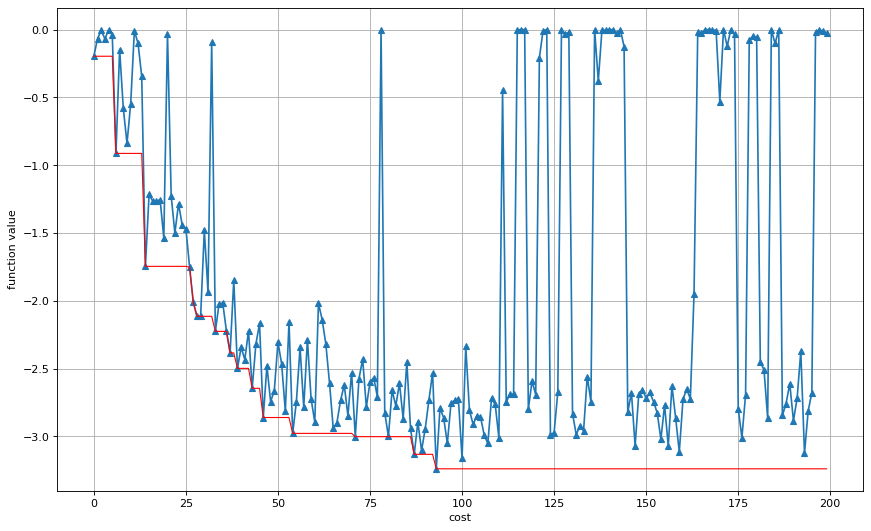

In [21]:
pl.figure(figsize=(13, 8), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "-^")
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=1)
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [22]:
gp.X[np.argmin(gp.y)], np.min(gp.y)

(array([0.167 , 0.0998, 0.4199, 0.2956, 0.3151, 0.6547]), -3.238557098204487)

In [23]:
gp.get_hyper()

{'var': 42.27331671671171, 'lengthscale': 0.5745552346163892}